In [1]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
# os.environ['NUMBA_DISABLE_JIT'] = '1'  # uncomment this if you want to use pypfopt within simulation
from numba import njit
from scipy.sparse import csr_matrix
import re

# from pypfopt.efficient_frontier import EfficientFrontier
# from pypfopt import risk_models
# from pypfopt import expected_returns
# from pypfopt import base_optimizer

import vectorbt as vbt
from vectorbt.generic.nb import nanmean_nb
from vectorbt.portfolio.nb import create_order_nb, auto_call_seq_ctx_nb
from vectorbt.portfolio.enums import SizeType, Direction

### Read this again

I need to take full advantage of the indexing before i start bulding stuff outside of it. Reread this to understand how he's doing a dict of multiple cols or whatev. Its multi asset. https://polakowo.medium.com/stop-loss-trailing-stop-or-take-profit-2-million-backtests-shed-light-dde23bda40be



In [494]:
# df = pd.read_csv('/Users/xbno/Downloads/pred_bt_gt_1_lo.csv.gz')
# df = pd.read_csv('/Users/xbno/Downloads/leftjoin.csv')
# df = pd.read_csv('/Users/xbno/Downloads/leftjoino.csv')
df = pd.read_csv('/Users/xbno/Downloads/20210101_pred_bt_full_version_64.csv')
df['oc_hx_date'] = pd.to_datetime(df['oc_hx_date'])
df['s_hx_date'] = pd.to_datetime(df['s_hx_date'])
df.set_index(["oc_hx_date", "oc_hx_contract_symbol"], inplace=True)
df = df.sort_index()
# df.head().T

/Users/xbno/anaconda3/envs/fin/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning:

Columns (0,2,3) have mixed types.Specify dtype option on import or set low_memory=False.



### Create entry/exit for vectorbt - fails on local due to int32 overflow/mem

Same shape as option_contract price history. Need to shift these 1 position downward so to simulate buying the next day.

These are the trades to copy:

In [467]:
df[~df['contract_symbol'].isnull()].head().T
# df.memory_usage(deep=True)

oc_hx_date                          2021-02-01                           \
oc_hx_contract_symbol        AA210219C00021000        AA210319C00021000   
contract_symbol              AA210219C00021000        AA210319C00021000   
y_pred                                  1.8175                  1.78258   
purch_date                          2021-02-01               2021-02-01   
purch_datetime         2021-02-01 09:50:30.606  2021-02-01 15:25:27.173   
trade_price                               0.37                        1   
open_day_after_purch                      0.45                      1.3   
lo_day_after_purch                        0.35                     0.95   
win                                          1                        1   
loss                                         0                        0   
close_day_of_exp                          2.17                    10.35   
exp_pct                                4.86486                     9.35   
future_intra_hi                            2.3                     11.5   
future_intra_hi_pct                    5.21622                     10.5   
future_intra_lo                           0.31                     1.39   
future_intra_lo_pct                  -0.162162                     0.39   
oc_hx_symbol                                AA                       AA   
oc_hx_hi                                  0.42                     1.05   
oc_hx_lo                                  0.26                     0.76   
oc_hx_open                                0.35                     0.78   
oc_hx_close                               0.39                     0.99   
s_hx_symbol                                 AA                       AA   
s_hx_hi                                  18.89                    18.89   
s_hx_lo                                  17.78                    17.78   
s_hx_open                                18.49                    18.49   
s_hx_close                               18.82                    18.82   
s_hx_date                  2021-02-01 00:00:00      2021-02-01 00:00:00   

oc_hx_date                                                               \
oc_hx_contract_symbol       AAL210219C00021000       AAL210219C00021500   
contract_symbol             AAL210219C00021000       AAL210219C00021500   
y_pred                                 1.54599                  1.51745   
purch_date                          2021-02-01               2021-02-01   
purch_datetime         2021-02-01 13:26:31.825  2021-02-01 14:55:34.484   
trade_price                               0.27                     0.33   
open_day_after_purch                       0.3                     0.19   
lo_day_after_purch                        0.16                     0.16   
win                                          0                        0   
loss                                         1                        1   
close_day_of_exp                          0.01                     0.02   
exp_pct                              -0.962963                -0.939394   
future_intra_hi                           0.32                     0.25   
future_intra_hi_pct                   0.185185                -0.242424   
future_intra_lo                           0.02                     0.03   
future_intra_lo_pct                  -0.925926                -0.909091   
oc_hx_symbol                               AAL                      AAL   
oc_hx_hi                                  0.48                     0.52   
oc_hx_lo                                  0.26                     0.24   
oc_hx_open                                0.48                     0.52   
oc_hx_close                                0.3                     0.27   
s_hx_symbol                                AAL                      AAL   
s_hx_hi                                  17.33                    17.33   
s_hx_lo                                  16.33                    16.33   
s_hx_open               

### Create entry/exit for vectorbt - Working with reduced symbols

Same shape as option_contract price history. Need to shift these 1 position downward so to simulate buying the next day.

These are the trades to copy:

In [499]:
rand_symbols = np.random.choice(df[~df['contract_symbol'].isnull()]['s_hx_symbol'].unique(),size=100)
rand_contract_symbols = df[(~df['contract_symbol'].isnull())&(df['s_hx_symbol'].isin(rand_symbols))]['contract_symbol']

In [472]:
# df = df[(df['s_hx_symbol'].isin(['BB','AMC','FEYE']))&(df['s_hx_date'] >= '2020-12-01')]
# df = df[(df['contract_symbol'].isin(rand_contract_symbols))&(df['s_hx_date'] >= '2020-12-01')]
df = df.loc[idx[:,rand_contract_symbols],:]
df.shape

(3911, 26)

In [505]:
rand = vbt.RAND.run(n=[i for i in range(df.shape[1])], input_shape=(df.shape[0],), seed=42)
entries = rand.entries
exits = rand.exits

entries.iloc[:,:] = False
entries.iloc[0,:] = True
exits.iloc[:,:] = False

In [506]:
entry_df = df.reset_index().groupby(['oc_hx_date','oc_hx_contract_symbol'])['contract_symbol'].last().unstack()
entry_df = entry_df.shift(1)
entry_df = entry_df.fillna(False)
entry_df = entry_df.replace({c:True for c in entry_df.columns})
# entry_df.columns = df_tmp.columns

In [507]:
# assert entry_df.loc['2020-12-08'].all() == False  # original trade check
# assert entry_df.sum().sum() == 20
# assert entry_df.loc['2020-12-09'].sum() == 6  # shifted check

In [508]:
def parse_contract_symbol(cs):
    "expects contract symbol like 'WKHS200717C00002500' and returns formatted versions of gleenable info to add to df"
    if isinstance(cs,str):
        cs = cs
#     elif isinstance(cs,pd.DataFrame):
#         cs = row['contract_symbol']
#     elif isinstance(cs,pd.Series):
#         cs = row['contract_symbol']
    else:
        cs = cs['contract_symbol']
    price_part = cs[-8:]
    option_type = cs[-9]
    date_part = cs[-15:-9]
    root_part = cs[:-15]
    symbol_part = re.match("[A-Z]*", root_part).group()

    price_part = int(price_part) / 1000
    type_part = {"C": "CALL", "P": "PUT"}[option_type]
    date_part = datetime.strptime(date_part, "%y%m%d").strftime("%Y-%m-%d")

    return {
        "option_expiration": date_part,
        "symbol": symbol_part,
        "root": root_part,
        "strike": price_part,
        "type": type_part,
    }

In [509]:
exp_exit_df = entry_df.copy()
exp_exit_df.iloc[:,:] = False

entry_exit_df = df.dropna(subset=['contract_symbol'])
entry_exit_df[['option_expiration','symbol','root','strike','type']] = entry_exit_df.apply(parse_contract_symbol,axis=1,result_type="expand")
entry_exit_df = entry_exit_df[['contract_symbol','option_expiration','purch_date']].drop_duplicates()
exits = entry_exit_df[['contract_symbol','option_expiration']].drop_duplicates().to_dict('records')

for exit in exits:
    exp_exit_df.loc[exit['option_expiration'],exit['contract_symbol']] = True

/Users/xbno/anaconda3/envs/fin/lib/python3.8/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Setup wide data for vectorbt

One column per option_contract series

In [514]:
df_tmp = df[[c for c in df.columns if 'oc_hx' in c]]
df_tmp = df_tmp.reset_index().set_index('oc_hx_date') #.set_index('oc_hx_symbol')
df_tmp = df_tmp.sort_index()
df_tmp = df_tmp.groupby(['oc_hx_date','oc_hx_contract_symbol'])['oc_hx_close'].max().unstack().dropna(how='all')

for exit in exits:
    df_tmp.loc[:exit['option_expiration'],exit['contract_symbol']] = df_tmp.loc[:exit['option_expiration'],exit['contract_symbol']].ffill()

df_tmp.index.name = 'Date'

def format_date(d):
    return datetime.strptime(d,'%y%m%d').strftime('%Y-%m-%d')

df_tmp_save = df_tmp.copy()

# old single index
# df_tmp = df_tmp.vbt.stack_index(pd.Index([re.match('[A-Z]*',c)[0] for c in df_tmp.columns], name='symbol'))
# df_tmp.vbt.stack_index(pd.Index([format_date(re.search('[0-9]+',c)[0]) for c in df_tmp.columns], name='option_expiration'))

# new multi index
multi_ind = list(zip(
    [{'P':'Put','C':'Call'}[re.search('[0-9]([CP])[0-9]',c)[1]] for c in df_tmp.columns],
    [re.match('[A-Z]*',c)[0] for c in df_tmp.columns],
    [format_date(re.search('[0-9]+',c)[0]) for c in df_tmp.columns]
))
df_tmp = df_tmp.vbt.stack_index(pd.MultiIndex.from_tuples(multi_ind, names=["option_type", "symbol", "option_expiration"]))
df_tmp

option_type                         Call                     \
symbol                               AAL                      
option_expiration             2021-02-12                      
oc_hx_contract_symbol AAL210212C00019000 AAL210212C00020000   
Date                                                          
2021-01-04                          0.43               0.33   
2021-01-05                          0.39               0.29   
2021-01-06                          0.42               0.25   
2021-01-07                          0.31               0.22   
2021-01-08                          0.26               0.17   
...                                  ...                ...   
2021-06-07                           NaN                NaN   
2021-06-08                           NaN                NaN   
2021-06-09                           NaN                NaN   
2021-06-10                           NaN                NaN   
2021-06-11                           NaN                NaN   

option_type                                                  \
symbol                                                        
option_expiration                                             
oc_hx_contract_symbol AAL210212C00020500 AAL210212C00023000   
Date                                                          
2021-01-04                          0.27               0.15   
2021-01-05                          0.27               0.13   
2021-01-06                          0.27               0.13   
2021-01-07                          0.23               0.13   
2021-01-08                          0.17               0.13   
...                                  ...                ...   
2021-06-07                           NaN                NaN   
2021-06-08                           NaN                NaN   
2021-06-09                           NaN                NaN   
2021-06-10                           NaN                NaN   
2021-06-11                           NaN                NaN   

option_type                                                  \
symbol                                                        
option_expiration                                2021-02-19   
oc_hx_contract_symbol AAL210212C00025000 AAL210219C00017000   
Date                                                          
2021-01-04                           NaN               0.92   
2021-01-05                           NaN               0.92   
2021-01-06                          0.06               0.85   
2021-01-07                          0.06               0.79   
2021-01-08                          0.06               0.65   
...                                  ...                ...   
2021-06-07                           NaN                NaN   
2021-06-08                           NaN                NaN   
2021-06-09                           NaN                NaN   
2021-06-10                           NaN                NaN   
2021-06-11                           NaN                NaN   

option_type                                                  \
symbol                                                        
option_expiration                                             
oc_hx_contract_symbol AAL210219C00017500 AAL210219C00018000   
Date                                                          
2021-01-04                           NaN               0.69   
2021-01-05                           NaN               0.67   
2021-01-06                           NaN               0.59   
2021-01-07                           NaN               0.55   
2021-01-08                           NaN               0.44   
...                                  ...                ...   
2021-06-07                           NaN                NaN   
2021-06-08                           NaN                NaN   
2021-06-09                           NaN                NaN   
2021-06-10                           NaN                NaN   
2021-06-11                  

### Create multiple random exits

Compare random exits to the exiting at expiration

In [549]:
exit_df = exp_exit_df.copy()
exit_df.columns = df_tmp.columns
entry_df.columns = df_tmp.columns

rand_exit_types = [f'rand_{i}' for i in range(10)]
rand_exit_dfs = {}
for rand_exit_type in rand_exit_types:
    rand_exit_df = vbt.IRPROBEX.run(
        entry_df, 
        df_tmp,
    ).exits
    rand_exit_df.columns = entry_df.columns
    rand_exit_dfs[rand_exit_type] = rand_exit_df

# for r in rand_exit_types:
#     print(f"rand_exit_dfs['{r}'],")
    
exit_types = rand_exit_types + ['expiration']
all_exit_df = pd.DataFrame.vbt.concat(
    rand_exit_dfs['rand_0'],
    rand_exit_dfs['rand_1'],
    rand_exit_dfs['rand_2'],
    rand_exit_dfs['rand_3'],
    rand_exit_dfs['rand_4'],
    rand_exit_dfs['rand_5'],
    rand_exit_dfs['rand_6'],
    rand_exit_dfs['rand_7'],
    rand_exit_dfs['rand_8'],
    rand_exit_dfs['rand_9'],
    exp_exit_df,
    keys=pd.Index(exit_types, name='exit_type')
)

In [552]:
assert df_tmp.shape == entry_df.shape == exp_exit_df.shape
# assert df_tmp.columns == entry_df.columns == exp_exit_df.columns

### Show trades

This is excellent! Potentially figure out how to add this to a dashboard with a selector. 

Inspiration also here: https://nbviewer.jupyter.org/github/polakowo/vectorbt/blob/master/examples/PortfolioOptimization.ipynb Looks like there could be a much better way of indexing these.


### Dashboard inspiration
Probably will need to create a dashboard using dash components: https://github.com/facultyai/dash-bootstrap-components like this: https://github.com/polakowo/vectorbt/tree/master/apps/candlestick-patterns.

Example here: https://candlestick-patterns.herokuapp.com/

In [553]:
contract_symbol = df_tmp.columns[-1]

fig = df_tmp[contract_symbol].dropna().vbt.plot(trace_kwargs=dict(name=f'{contract_symbol}'))
fig = entry_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_entry_markers(df_tmp[contract_symbol].dropna(), fig=fig)
fig = exit_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_exit_markers(df_tmp[contract_symbol].dropna(), fig=fig)

contract_symbol = df_tmp.columns[-21]
fig = df_tmp[contract_symbol].dropna().vbt.plot(trace_kwargs=dict(name=f'{contract_symbol}'), fig=fig)
fig = entry_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_entry_markers(df_tmp[contract_symbol].dropna(), fig=fig)
fig = exit_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_exit_markers(df_tmp[contract_symbol].dropna(), fig=fig)

fig.show()

In [519]:
symbol = 'FEYE'
option_expiration = '2021-01-08'
option_type = 'Call'
contract_symbols = [
    c for c in df_tmp.columns 
        if symbol in c 
        and option_expiration in c
        and option_type in c
]
print(f"{len(contract_symbols)} Traces")
contract_symbol = contract_symbols[0]
fig = df_tmp[contract_symbol].dropna().vbt.plot(trace_kwargs=dict(name=f'{contract_symbol}'))
fig = entry_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_entry_markers(df_tmp[contract_symbol].dropna(), fig=fig)
fig = exit_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_exit_markers(df_tmp[contract_symbol].dropna(), fig=fig)

for contract_symbol in contract_symbols[1:50]:
    fig = df_tmp[contract_symbol].dropna().vbt.plot(trace_kwargs=dict(name=f'{contract_symbol}'), fig=fig)
    fig = entry_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_entry_markers(df_tmp[contract_symbol].dropna(), fig=fig)
    fig = exit_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_exit_markers(df_tmp[contract_symbol].dropna(), fig=fig)

fig.update_layout(
    autosize=False,
    width=1200,
    height=800,)
fig.show()

0 Traces


IndexError: list index out of range

### Working with pd.MultiIndex

Slicing

In [554]:
# find example to inspect
# entry_df.sum()[entry_df.sum()!=0]
# a = entry_df.loc(axis=1)[:,:,:,['AMC210305C00007000']]
# a[a].dropna()

idx = pd.IndexSlice
entry_df.loc[idx['2021-02-17'],idx[:,:,:,['AMC210305C00007000']]]

Series([], Name: 2021-02-17 00:00:00, dtype: bool)

### Create vectorbt portfolio.from_orders()

Join entry_df and exit_df that had been created for the signals version to create +/- values for orders

In [214]:
# entry_sz = entry_df.astype(int) * 10 * 100
# exit_sz = exit_df.astype(int) * entry_sz.sum()
# entry_exit_sz = entry_sz - exit_sz

# # converts old pandas entry_exit_sz sparse version (didn't work as sparse, so unnecessary)
# row = []
# col = []
# data = []
# for i,r in enumerate(entry_exit_sz.index):
#     for j,c in enumerate(entry_exit_sz.columns):
#         if entry_exit_sz.loc[r,c] == 0:
#             continue
#         else:
#             row.append(i)
#             col.append(j)
#             data.append(entry_exit_sz.loc[r,c])

# col_size = j+1
# row_size = i+1

# # entry_exit_sz = csr_matrix((data, (row, col)), shape=((row_size,col_size)))  # doesnt' work
# entry_exit_sz = csr_matrix((data, (row, col)), shape=((row_size,col_size))).toarray()

In [27]:
# portfolio = vbt.Portfolio.from_orders(
# #     df_tmp,
#     price,
#     size=entry_exit_sz, 
#     min_size=0,
#     max_size=10000, 
# #     group_by=True,
# #     group_by=symbol_groups, 
#     log=True, 
#     fees=0.001, 
#     slippage=0.001,
# #     init_cash='auto',
#     init_cash='autoalign',
# #     cash_sharing=True, 
#     direction='longonly',
#     freq='1D',
# )

# portfolio.total_return()

# Brainstorming

### Entry logic
- Only buy at 1/2 price of original trade
- Buy X at orig price, Y at .75 * orig price, Z at .5 * orig price. Good til expired
- 

### Exit logic
- Set X% stop loss for Z% of shares, after Y% increase
    - Sell 1/2 of shares at 20% max drawdown, after hitting 50% increase
- Sell Z% of shares after Y% increase 
    - Sell all shares after 100% increase
    - Sell 1/2 shares after 100% increase and other 1/2 after 200% increase

### Create vectorbt portfolio.from_orders()

Create rand exiting to compare to expiration exiting. Inspired from: https://nbviewer.jupyter.org/github/polakowo/vectorbt/blob/master/examples/StopSignals.ipynb

The idea is that if I can create exit signals based on actual functions than I can actually beomce confident in which is the best/safest method overall.

- Entry signal same for all
- Exit signal random each time

In [555]:
df_tmp

option_type                         Call                     \
symbol                               AAL                      
option_expiration             2021-02-12                      
oc_hx_contract_symbol AAL210212C00019000 AAL210212C00020000   
Date                                                          
2021-01-04                          0.43               0.33   
2021-01-05                          0.39               0.29   
2021-01-06                          0.42               0.25   
2021-01-07                          0.31               0.22   
2021-01-08                          0.26               0.17   
...                                  ...                ...   
2021-06-07                           NaN                NaN   
2021-06-08                           NaN                NaN   
2021-06-09                           NaN                NaN   
2021-06-10                           NaN                NaN   
2021-06-11                           NaN                NaN   

option_type                                                  \
symbol                                                        
option_expiration                                             
oc_hx_contract_symbol AAL210212C00020500 AAL210212C00023000   
Date                                                          
2021-01-04                          0.27               0.15   
2021-01-05                          0.27               0.13   
2021-01-06                          0.27               0.13   
2021-01-07                          0.23               0.13   
2021-01-08                          0.17               0.13   
...                                  ...                ...   
2021-06-07                           NaN                NaN   
2021-06-08                           NaN                NaN   
2021-06-09                           NaN                NaN   
2021-06-10                           NaN                NaN   
2021-06-11                           NaN                NaN   

option_type                                                  \
symbol                                                        
option_expiration                                2021-02-19   
oc_hx_contract_symbol AAL210212C00025000 AAL210219C00017000   
Date                                                          
2021-01-04                           NaN               0.92   
2021-01-05                           NaN               0.92   
2021-01-06                          0.06               0.85   
2021-01-07                          0.06               0.79   
2021-01-08                          0.06               0.65   
...                                  ...                ...   
2021-06-07                           NaN                NaN   
2021-06-08                           NaN                NaN   
2021-06-09                           NaN                NaN   
2021-06-10                           NaN                NaN   
2021-06-11                           NaN                NaN   

option_type                                                  \
symbol                                                        
option_expiration                                             
oc_hx_contract_symbol AAL210219C00017500 AAL210219C00018000   
Date                                                          
2021-01-04                           NaN               0.69   
2021-01-05                           NaN               0.67   
2021-01-06                           NaN               0.59   
2021-01-07                           NaN               0.55   
2021-01-08                           NaN               0.44   
...                                  ...                ...   
2021-06-07                           NaN                NaN   
2021-06-08                           NaN                NaN   
2021-06-09                           NaN                NaN   
2021-06-10                           NaN                NaN   
2021-06-11                  

In [556]:
def uniform_cash_order_sizing(df_tmp,entry_size_df,max_cash_per_trade=150,return_share_size=True):
    entry_contract_size_df = (max_cash_per_trade // (df_tmp * 100 * entry_size_df)).replace([np.inf, -np.inf], np.nan).fillna(0)
    if return_share_size:
        return entry_contract_size_df * 100
    else:
        return entry_contract_size_df

uniform_cash_order_sizing(df_tmp,entry_df.copy().astype(int),100).loc[idx['2021-02-17'],idx[:,:,:,['AMC210305C00007000']]]

Series([], Name: 2021-02-17 00:00:00, dtype: float64)

In [557]:
def uniform_quantity_order_sizing(df_tmp,entry_size_df,max_quantity_per_trade=10):
    return (max_quantity_per_trade * entry_size_df).replace([np.inf, -np.inf], np.nan).fillna(0)

uniform_quantity_order_sizing(df_tmp,entry_df.copy().astype(int),500).loc[idx['2021-02-17'],idx[:,:,:,['AMC210305C00007000']]]

Series([], Name: 2021-02-17 00:00:00, dtype: int64)

In [558]:
import gc

max_cash_per_trade = 500
total_returns = []
for exit_type in exit_types:
    entry_size_df = uniform_cash_order_sizing(df_tmp,entry_df.copy().astype(int),max_cash_per_trade)
    chunk_exit_df = all_exit_df.loc[:,all_exit_df.columns.get_level_values('exit_type') == exit_type]
    entry_size_df.columns = chunk_exit_df.columns
    exit_size_df = chunk_exit_df.astype(int) * entry_size_df.sum()
    entry_exit_size_df = entry_size_df - exit_size_df
    
    portfolio = vbt.Portfolio.from_orders(
        df_tmp,  # grouped by exit_type, symbol, contract_symbol
        size=entry_exit_size_df, 
        min_size=0,
        max_size=5000, 
        log=True, 
        fees=0.001, 
        slippage=0.00,
        init_cash='autoalign', #50000,
        direction='longonly',
        freq='1D',
    )
    total_returns.append(portfolio.total_return())

    if exit_type == 'expiration':
        pass
    else:
        del portfolio
    gc.collect()
    
total_return = pd.concat(total_returns)

print(total_return.shape)

(9735,)


In [563]:
total_return_by_type = total_return.unstack(level='exit_type')[exit_types]

print(pd.DataFrame({
    'Mean': total_return_by_type.mean(),
    'Median': total_return_by_type.median(),
    'Std': total_return_by_type.std(),
}))

total_return_by_type.vbt.boxplot(
    yaxis_title='Total return',
    yaxis_tickformat='%'
).show()


                Mean    Median       Std
exit_type                               
rand_0     -0.007835 -0.012344  0.220222
rand_1     -0.007316 -0.008627  0.190452
rand_2     -0.005101 -0.012199  0.195334
rand_3     -0.004253 -0.010555  0.191455
rand_4     -0.013058 -0.013380  0.171683
rand_5     -0.007863 -0.010714  0.204676
rand_6     -0.007304 -0.012058  0.228017
rand_7     -0.009122 -0.012003  0.183447
rand_8     -0.014541 -0.011970  0.185341
rand_9     -0.009233 -0.011025  0.178610
expiration -0.008578 -0.040308  0.352071


### Portfolio: Trades, Orders. Not sure what to do with these yet

All columns show the current snapshot prior to fulfilling the log record action. For example, cash now = 50000 on the first trade. shares now = 0 on the first trade. Also, every cell is traversed during the calculations and `non_order` logs are `-1`

Columns of Note:
- `cash_now`: the total cash in the portfolio
- `value_now`: the total portfolio value (cash + positions held)

In [564]:
order_df = portfolio.logs.records
order_df[order_df['order_id'] != -1].head(2).T

,22,28
id,22,28
idx,22,28
col,0,0
group,0,0
cash_now,inf,inf
shares_now,0,2500
val_price_now,0.2,0.03
value_now,inf,inf
size,2500,-2500
size_type,0,0


In [565]:
portfolio.orders.records

,id,idx,col,size,price,fees,side
0,0,22,0,2500.0,0.20,0.500,0
1,1,28,0,2500.0,0.03,0.075,1
2,2,22,1,3800.0,0.13,0.494,0
3,3,28,1,3800.0,0.01,0.038,1
4,4,22,2,3800.0,0.13,0.494,0
...,...,...,...,...,...,...,...
3074,3074,96,882,300.0,0.02,0.006,1
3075,3075,94,883,1900.0,0.26,0.494,0
3076,3076,101,883,1900.0,0.01,0.019,1
3077,3077,49,884,1200.0,0.40,0.480,0


In [566]:
trades_df = portfolio.trades.records
trades_df['pnl'].sum()

13219.605511852264

### Ratios, Profits, etc

When running this for all symbols, I can do ablation on the top X and figure out the what the gains would still be. If I'm clever about it, I can include the symbol price history as well, and ablate based on the gains of it? That way I could remove abnormally high winners, like AMC, BB recently.

In [567]:
# can group by in order like this, but not alone
portfolio.total_return(group_by=['symbol'])
portfolio.total_return(group_by=['symbol','option_expiration'])
portfolio.total_return(group_by=['symbol','option_expiration','option_type'])
portfolio.total_return(group_by='exit_type')
# portfolio.total_return(group_by='option_type').sort_values(ascending=False)  # ValueError: Groups must be coherent and sorted

portfolio.total_return(group_by=['symbol'])

symbol
AAL      -0.212735
AAP       0.001540
ACM      -0.012569
AEM       0.024529
ATCO     -0.008071
            ...   
WWR      -0.161410
XPO      -0.004531
ZNGA     -0.330032
ZS       -0.023586
ZYNE     -0.004196
Length: 91, dtype: float64

In [568]:
# drop_half = portfolio.total_return().index.shape[0] // 2
# portfolio.total_return(group_by=False).sort_values(ascending=False).index[drop_half:]

# option_expiration = '2021-01-08'
# select_index = [i for i,c in enumerate(portfolio.total_return().index) if option_expiration in c]
# portfolio.total_return(group_by=False).index[select_index]

# unablated_contract_symbols = portfolio.total_return(group_by=False).sort_values(ascending=False).index[3:]
# unablated_contract_symbols

# portfolio.regroup(group_by='option_expiration').total_return(group_by='option_expiration')

In [569]:
portfolio.regroup(group_by=None).total_profit().sum()

-85973.47700000003

In [570]:
portfolio.stats()

/Users/xbno/anaconda3/envs/fin/lib/python3.8/site-packages/vectorbt/portfolio/trades.py:232: RuntimeWarning:

invalid value encountered in true_divide



Start                            2021-01-04 00:00:00
End                              2021-06-11 00:00:00
Duration                           111 days 00:00:00
Init. Cash                                   11324.3
Total Profit                                -97.1452
Total Return [%]                           -0.857846
Benchmark Return [%]                        -16.0867
Position Coverage [%]                        24.5971
Max. Drawdown [%]                            8.29281
Avg. Drawdown [%]                            4.34924
Max. Drawdown Duration    40 days 00:21:16.847290640
Avg. Drawdown Duration    25 days 02:09:16.340605207
Num. Trades                                 0.963842
Win Rate [%]                                 20.3986
Best Trade [%]                              -15.1226
Worst Trade [%]                             -15.1226
Avg. Trade [%]                              -15.1226
Max. Trade Duration       18 days 08:34:53.317702227
Avg. Trade Duration       18 days 08:34:53.317

In [572]:
(portfolio.sortino_ratio(group_by='symbol'),
portfolio.sharpe_ratio(group_by='symbol'),
portfolio.omega_ratio(risk_free=.02,required_return=.05,group_by='symbol'))

(symbol
 AAL     3.537658
 AAP     0.531907
 ACM    -2.117784
 AEM     4.150852
 ATCO   -2.054848
           ...   
 WWR    -4.799171
 XPO    -0.899465
 ZNGA   -5.072111
 ZS     -2.931459
 ZYNE   -4.206086
 Length: 91, dtype: float64,
 symbol
 AAL     1.332299
 AAP     0.349993
 ACM    -1.497266
 AEM     1.755898
 ATCO   -1.589905
           ...   
 WWR    -4.276432
 XPO    -0.685482
 ZNGA   -3.880949
 ZS     -2.228166
 ZYNE   -4.189612
 Length: 91, dtype: float64,
 symbol
 AAL     0.546984
 AAP     0.000000
 ACM     0.000000
 AEM     0.000000
 ATCO    0.000000
           ...   
 WWR     0.000000
 XPO     0.000000
 ZNGA    0.040338
 ZS      0.000000
 ZYNE    0.000000
 Length: 91, dtype: float64)

In [1196]:
# portfolio.total_return()
# portfolio.value()
# # one_group = pd.Index(['one' for c in df_tmp.columns], name='group')
# # portfolio.net_exposure(group_by=symbol_groups)#.sum(axis=1).plot() #drawdown()
# portfolio.net_exposure()#.sum(axis=1).plot() #drawdown()

In [573]:
portfolio.total_profit(group_by='symbol')

symbol
AAL    -22538.796
AAP       163.155
ACM     -1331.620
AEM      2598.789
ATCO     -855.082
          ...    
WWR    -17100.967
XPO      -480.032
ZNGA   -34966.033
ZS      -2498.826
ZYNE     -444.516
Length: 91, dtype: float64

# Digging into best/worst Trades

Need to figure out how to gather all the entries for a single contract into a single graph for the profit and loss. Also need to restriction of only allowing X amount of money into a given contract, if it already has so many already being held

In [574]:
from vectorbt.portfolio.enums import OrderStatus
order_status_df = portfolio.logs.map_field('res_status', value_map=OrderStatus).value_counts()
contracts = order_status_df.loc[:,order_status_df.loc['Ignored'] != 111].columns.tolist()

In [575]:
# unkonwn whats good about this
# portfolio.total_profit(group_by=None).reset_index().groupby(['symbol','option_expiration'])[0].sum()
# a = portfolio.total_profit(group_by=None).reset_index()
# a[a['symbol'] == 'FEYE'].groupby(['symbol','option_expiration'])[0].sum().plot()

In [576]:
portfolio[contracts].total_profit().reset_index().sort_values(by=[0],ascending=False)
# portfolio[contracts].total_profit().reset_index().sort_values(by=[0],ascending=False)[0].hist(bins=50)

,exit_type,option_type,symbol,option_expiration,oc_hx_contract_symbol,0
562,expiration,Call,ORCL,2021-04-16,ORCL210416C00070000,51336.931
564,expiration,Call,ORCL,2021-04-16,ORCL210416C00072500,50822.398
565,expiration,Call,ORCL,2021-04-16,ORCL210416C00075000,39394.663
59,expiration,Call,AAL,2021-03-19,AAL210319C00022000,34136.108
520,expiration,Call,NOK,2021-05-21,NOK210521C00004500,23411.124
...,...,...,...,...,...,...
438,expiration,Call,IPOF,2021-04-16,IPOF210416C00012500,-7726.157
119,expiration,Call,AAL,2021-04-16,AAL210416C00025000,-8352.528
65,expiration,Call,AAL,2021-03-19,AAL210319C00025000,-8881.323
162,expiration,Call,AAL,2021-05-21,AAL210521C00024000,-9640.069


In [590]:
# get single cidx
# cidx = [i for i,c in enumerate(contracts) if 'AMC210528C00012000' in c][0]
# cidx = [i for i,c in enumerate(contracts) if 'AMC210521C00014000' in c][0]
# cidx = [i for i,c in enumerate(contracts) if 'BB210521C00011000' in c][0]
symbol = 'WWR210219C00015000'#'AAL210521C00025000'
cidx = [i for i,c in enumerate(contracts) if symbol in c][0]




# cidx = 172
portfolio.trades[contracts[cidx][:4]][contracts[cidx][-1]].plot().show()
# portfolio[contracts[cidx][:4]][contracts[cidx][-1]].cumulative_returns().vbt.plot().show()
# portfolio[contracts[cidx][:4]][contracts[cidx][-1]].get_drawdowns().plot().show()
entry_exit_size_df[contracts[cidx][:4]][contracts[cidx][-1]].vbt.plot().show()

# portfolio.trades['expiration']['Call']['AMC']['2021-03-05']['AMC210305C00007000'].plot().show()
# portfolio['expiration']['Call']['AMC']['2021-03-05']['AMC210305C00007000'].cumulative_returns().vbt.plot()

In [593]:
# fig = portfolio['expiration']['Call']['AMC']['2021-03-05']['AMC210305C00007000'].plot(subplots=[
#     'orders',
#     ('order_size', dict(
#         title='Order Size',
#         can_plot_groups=False
#     ))  # placeholder
# ])
# entry_exit_size_df['expiration']['Call']['AMC']['2021-03-05']['AMC210305C00007000'].vbt.plot(add_trace_kwargs=dict(row=2, col=1), fig=fig).show()

# thing = ('expiration','Call','AMC','2021-03-05','AMC210305C00007000')
# portfolio[thing].total_return() == portfolio['expiration']['Call']['AMC']['2021-03-05']['AMC210305C00007000'].total_return()
# portfolio.trades[thing].plot_pnl()

In [595]:
win_rate_df = portfolio.trades.win_rate().dropna().reset_index()
win_rate_df.groupby(['symbol'])[0].describe()

,count,mean,std,min,25%,50%,75%,max
symbol,,,,,,,,
AAL,195.0,0.220513,0.403068,0.0,0.00,0.0,0.00,1.0
AAP,2.0,0.500000,0.707107,0.0,0.25,0.5,0.75,1.0
ACM,1.0,0.000000,NaN,0.0,0.00,0.0,0.00,0.0
AEM,3.0,0.666667,0.577350,0.0,0.50,1.0,1.00,1.0
ATCO,1.0,0.000000,NaN,0.0,0.00,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...
WWR,10.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0
XPO,3.0,0.333333,0.577350,0.0,0.00,0.0,0.50,1.0
ZNGA,35.0,0.085714,0.284029,0.0,0.00,0.0,0.00,1.0


In [406]:
# regroup = ['a' for _ in range(portfolio.total_return().index.shape[0])]
# portfolio.regroup(group_by=[1 for i in range(9)]).trades.plot_pnl()

# thing = ['expiration','AMC','AMC210122C00002500']
# portfolio[thing].plot().show()
# portfolio['expiration']['AMC']['AMC210122C00002500'].plot().show()


In [408]:
# import numpy as np
# import pandas as pd
# from datetime import datetime
# import vectorbt as vbt

# start = datetime(2020, 1, 1)
# end = datetime(2020, 9, 1)
# close = vbt.utils.data.download("BTC-USD", start=start, end=end)['Close']

# np.random.seed(42)
# size = pd.Series.vbt.empty_like(close, fill_value=0.)
# n_orders = 20
# rand_idxs = np.random.randint(0, len(size), size=n_orders)
# size.iloc[rand_idxs] = np.random.uniform(-1, 1, size=n_orders)
# portfolio = vbt.Portfolio.from_orders(
#     close, size, direction='longonly',
#     init_cash='auto', freq='1D')
# portfolio.plot().show()

#size.plot()

### Examine portfolio methods

In [596]:
# portfolio.share_flow()
# portfolio.shares()

# portfolio.cash_flow()
portfolio.cash()

# portfolio.daily_returns(group_by=None)#.plot()

exit_type                     expiration                     \
option_type                         Call                      
symbol                               AAL                      
option_expiration             2021-02-12                      
oc_hx_contract_symbol AAL210212C00019000 AAL210212C00020000   
Date                                                          
2021-01-04                     11324.313          11324.313   
2021-01-05                     11324.313          11324.313   
2021-01-06                     11324.313          11324.313   
2021-01-07                     11324.313          11324.313   
2021-01-08                     11324.313          11324.313   
...                                  ...                ...   
2021-06-07                     10898.738          10867.781   
2021-06-08                     10898.738          10867.781   
2021-06-09                     10898.738          10867.781   
2021-06-10                     10898.738          10867.781   
2021-06-11                     10898.738          10867.781   

exit_type                                                    \
option_type                                                   
symbol                                                        
option_expiration                                             
oc_hx_contract_symbol AAL210212C00020500 AAL210212C00023000   
Date                                                          
2021-01-04                     11324.313          11324.313   
2021-01-05                     11324.313          11324.313   
2021-01-06                     11324.313          11324.313   
2021-01-07                     11324.313          11324.313   
2021-01-08                     11324.313          11324.313   
...                                  ...                ...   
2021-06-07                     10867.781          11023.913   
2021-06-08                     10867.781          11023.913   
2021-06-09                     10867.781          11023.913   
2021-06-10                     10867.781          11023.913   
2021-06-11                     10867.781          11023.913   

exit_type                                                    \
option_type                                                   
symbol                                                        
option_expiration                                2021-02-19   
oc_hx_contract_symbol AAL210212C00025000 AAL210219C00017000   
Date                                                          
2021-01-04                     11324.313          11324.313   
2021-01-05                     11324.313          11324.313   
2021-01-06                     11324.313          11324.313   
2021-01-07                     11324.313          11324.313   
2021-01-08                     11324.313          11324.313   
...                                  ...                ...   
2021-06-07                     11124.013          11416.398   
2021-06-08                     11124.013          11416.398   
2021-06-09                     11124.013          11416.398   
2021-06-10                     11124.013          11416.398   
2021-06-11                     11124.013          11416.398   

exit_type                                                    \
option_type                                                   
symbol                                                        
option_expiration                                             
oc_hx_contract_symbol AAL210219C00017500 AAL210219C00018000   
Date                                                          
2021-01-04                     11324.313          11324.313   
2021-01-05                     11324.313          11324.313   
2021-01-06                     11324.313          11324.313   
2021-01-07                     11324.313          11324.313   
2021-01-08                     11324.313          11324.313   
...                                  ...                ...   
2021-06-07                  

In [598]:
portfolio.market_returns()#.plot()

exit_type                     expiration                     \
option_type                         Call                      
symbol                               AAL                      
option_expiration             2021-02-12                      
oc_hx_contract_symbol AAL210212C00019000 AAL210212C00020000   
Date                                                          
2021-01-04                      0.000000           0.000000   
2021-01-05                     -0.093023          -0.121212   
2021-01-06                      0.076923          -0.137931   
2021-01-07                     -0.261905          -0.120000   
2021-01-08                     -0.161290          -0.227273   
...                                  ...                ...   
2021-06-07                      0.000000           0.000000   
2021-06-08                      0.000000           0.000000   
2021-06-09                      0.000000           0.000000   
2021-06-10                      0.000000           0.000000   
2021-06-11                      0.000000           0.000000   

exit_type                                                    \
option_type                                                   
symbol                                                        
option_expiration                                             
oc_hx_contract_symbol AAL210212C00020500 AAL210212C00023000   
Date                                                          
2021-01-04                      0.000000           0.000000   
2021-01-05                      0.000000          -0.133333   
2021-01-06                      0.000000           0.000000   
2021-01-07                     -0.148148           0.000000   
2021-01-08                     -0.260870           0.000000   
...                                  ...                ...   
2021-06-07                      0.000000           0.000000   
2021-06-08                      0.000000           0.000000   
2021-06-09                      0.000000           0.000000   
2021-06-10                      0.000000           0.000000   
2021-06-11                      0.000000           0.000000   

exit_type                                                    \
option_type                                                   
symbol                                                        
option_expiration                                2021-02-19   
oc_hx_contract_symbol AAL210212C00025000 AAL210219C00017000   
Date                                                          
2021-01-04                           0.0           0.000000   
2021-01-05                           0.0           0.000000   
2021-01-06                           0.0          -0.076087   
2021-01-07                           0.0          -0.070588   
2021-01-08                           0.0          -0.177215   
...                                  ...                ...   
2021-06-07                           0.0           0.000000   
2021-06-08                           0.0           0.000000   
2021-06-09                           0.0           0.000000   
2021-06-10                           0.0           0.000000   
2021-06-11                           0.0           0.000000   

exit_type                                                    \
option_type                                                   
symbol                                                        
option_expiration                                             
oc_hx_contract_symbol AAL210219C00017500 AAL210219C00018000   
Date                                                          
2021-01-04                           0.0           0.000000   
2021-01-05                           0.0          -0.028986   
2021-01-06                           0.0          -0.119403   
2021-01-07                           0.0          -0.067797   
2021-01-08                           0.0          -0.200000   
...                                  ...                ...   
2021-06-07                  

In [599]:
portfolio.active_returns()#.plot()

exit_type                     expiration                     \
option_type                         Call                      
symbol                               AAL                      
option_expiration             2021-02-12                      
oc_hx_contract_symbol AAL210212C00019000 AAL210212C00020000   
Date                                                          
2021-01-04                           0.0                0.0   
2021-01-05                           0.0                0.0   
2021-01-06                           0.0                0.0   
2021-01-07                           0.0                0.0   
2021-01-08                           0.0                0.0   
...                                  ...                ...   
2021-06-07                           0.0                0.0   
2021-06-08                           0.0                0.0   
2021-06-09                           0.0                0.0   
2021-06-10                           0.0                0.0   
2021-06-11                           0.0                0.0   

exit_type                                                    \
option_type                                                   
symbol                                                        
option_expiration                                             
oc_hx_contract_symbol AAL210212C00020500 AAL210212C00023000   
Date                                                          
2021-01-04                           0.0                0.0   
2021-01-05                           0.0                0.0   
2021-01-06                           0.0                0.0   
2021-01-07                           0.0                0.0   
2021-01-08                           0.0                0.0   
...                                  ...                ...   
2021-06-07                           0.0                0.0   
2021-06-08                           0.0                0.0   
2021-06-09                           0.0                0.0   
2021-06-10                           0.0                0.0   
2021-06-11                           0.0                0.0   

exit_type                                                    \
option_type                                                   
symbol                                                        
option_expiration                                2021-02-19   
oc_hx_contract_symbol AAL210212C00025000 AAL210219C00017000   
Date                                                          
2021-01-04                           0.0                0.0   
2021-01-05                           0.0                0.0   
2021-01-06                           0.0                0.0   
2021-01-07                           0.0                0.0   
2021-01-08                           0.0                0.0   
...                                  ...                ...   
2021-06-07                           0.0                0.0   
2021-06-08                           0.0                0.0   
2021-06-09                           0.0                0.0   
2021-06-10                           0.0                0.0   
2021-06-11                           0.0                0.0   

exit_type                                                    \
option_type                                                   
symbol                                                        
option_expiration                                             
oc_hx_contract_symbol AAL210219C00017500 AAL210219C00018000   
Date                                                          
2021-01-04                           0.0                0.0   
2021-01-05                           0.0                0.0   
2021-01-06                           0.0                0.0   
2021-01-07                           0.0                0.0   
2021-01-08                           0.0                0.0   
...                                  ...                ...   
2021-06-07                  

In [600]:
portfolio[contracts].cumulative_returns()

exit_type                     expiration                     \
option_type                         Call                      
symbol                               AAL                      
option_expiration             2021-02-12                      
oc_hx_contract_symbol AAL210212C00019000 AAL210212C00020000   
Date                                                          
2021-01-04                      0.000000           0.000000   
2021-01-05                      0.000000           0.000000   
2021-01-06                      0.000000           0.000000   
2021-01-07                      0.000000           0.000000   
2021-01-08                      0.000000           0.000000   
...                                  ...                ...   
2021-06-07                     -0.037581          -0.040314   
2021-06-08                     -0.037581          -0.040314   
2021-06-09                     -0.037581          -0.040314   
2021-06-10                     -0.037581          -0.040314   
2021-06-11                     -0.037581          -0.040314   

exit_type                                                    \
option_type                                                   
symbol                                                        
option_expiration                                             
oc_hx_contract_symbol AAL210212C00020500 AAL210212C00023000   
Date                                                          
2021-01-04                      0.000000           0.000000   
2021-01-05                      0.000000           0.000000   
2021-01-06                      0.000000           0.000000   
2021-01-07                      0.000000           0.000000   
2021-01-08                      0.000000           0.000000   
...                                  ...                ...   
2021-06-07                     -0.040314          -0.026527   
2021-06-08                     -0.040314          -0.026527   
2021-06-09                     -0.040314          -0.026527   
2021-06-10                     -0.040314          -0.026527   
2021-06-11                     -0.040314          -0.026527   

exit_type                                                    \
option_type                                                   
symbol                                                        
option_expiration                                2021-02-19   
oc_hx_contract_symbol AAL210212C00025000 AAL210219C00017000   
Date                                                          
2021-01-04                      0.000000           0.000000   
2021-01-05                      0.000000           0.000000   
2021-01-06                      0.000000           0.000000   
2021-01-07                      0.000000           0.000000   
2021-01-08                      0.000000           0.000000   
...                                  ...                ...   
2021-06-07                     -0.017688           0.008132   
2021-06-08                     -0.017688           0.008132   
2021-06-09                     -0.017688           0.008132   
2021-06-10                     -0.017688           0.008132   
2021-06-11                     -0.017688           0.008132   

exit_type                                                    \
option_type                                                   
symbol                                                        
option_expiration                                             
oc_hx_contract_symbol AAL210219C00017500 AAL210219C00018000   
Date                                                          
2021-01-04                      0.000000           0.000000   
2021-01-05                      0.000000           0.000000   
2021-01-06                      0.000000           0.000000   
2021-01-07                      0.000000           0.000000   
2021-01-08                      0.000000           0.000000   
...                                  ...                ...   
2021-06-07                  

In [601]:
portfolio[contracts].returns_stats()

Start                    2021-01-04 00:00:00
End                      2021-06-11 00:00:00
Duration                   111 days 00:00:00
Total Return [%]                   -0.890028
Benchmark Return [%]                -17.6235
Annual Return [%]                    111.919
Annual Volatility [%]                32.0373
Sharpe Ratio                        -1.33345
Calmar Ratio                         5.33845
Max. Drawdown [%]                   -13.3828
Omega Ratio                         0.886717
Sortino Ratio                      -0.852785
Skew                                -1.12487
Kurtosis                             27.4084
Tail Ratio                               inf
Common Sense Ratio                       inf
Value at Risk                     -0.0156394
Alpha                              0.0519789
Beta                               0.0388193
Name: <lambda>, dtype: object

In [603]:
(254*50000,
portfolio[contracts].final_value().sum(),
portfolio.final_value().sum())

(12700000, 9573665.512000002, 9936043.528)

In [604]:
portfolio[contracts].value_at_risk()

exit_type   option_type  symbol  option_expiration  oc_hx_contract_symbol
expiration  Call         AAL     2021-02-12         AAL210212C00019000       0.000000
                                                    AAL210212C00020000      -0.000022
                                                    AAL210212C00020500       0.000000
                                                    AAL210212C00023000       0.000000
                                                    AAL210212C00025000       0.000000
                                                                               ...   
                         ZS      2021-04-16         ZS210416C00210000       -0.005096
                                 2021-05-21         ZS210521C00210000       -0.009777
                                                    ZS210521C00220000       -0.004241
                                 2021-05-28         ZS210528C00210000       -0.001768
                         ZYNE    2021-04-16         ZYNE210416C000

In [605]:
portfolio.total_market_return()

exit_type   option_type  symbol  option_expiration  oc_hx_contract_symbol
expiration  Call         AAL     2021-02-12         AAL210212C00019000      -0.930233
                                                    AAL210212C00020000      -0.969697
                                                    AAL210212C00020500      -0.962963
                                                    AAL210212C00023000      -0.933333
                                                    AAL210212C00025000      -0.833333
                                                                               ...   
                         ZS      2021-04-16         ZS210416C00210000       -0.997906
                                 2021-05-21         ZS210521C00210000       -0.999505
                                                    ZS210521C00220000       -0.998758
                                 2021-05-28         ZS210528C00210000       -0.998106
                         ZYNE    2021-04-16         ZYNE210416C000

In [607]:
portfolio.total_profit().sort_values()

exit_type   option_type  symbol  option_expiration  oc_hx_contract_symbol
expiration  Call         AAL     2021-05-21         AAL210521C00025000      -10274.413
                                                    AAL210521C00024000       -9640.069
                                 2021-03-19         AAL210319C00025000       -8881.323
                                 2021-04-16         AAL210416C00025000       -8352.528
                         IPOF    2021-04-16         IPOF210416C00012500      -7726.157
                                                                               ...    
                         NOK     2021-05-21         NOK210521C00004500       23411.124
                         AAL     2021-03-19         AAL210319C00022000       34136.108
                         ORCL    2021-04-16         ORCL210416C00075000      39394.663
                                                    ORCL210416C00072500      50822.398
                                                    ORCL

In [608]:
portfolio.calmar_ratio()

exit_type   option_type  symbol  option_expiration  oc_hx_contract_symbol
expiration  Call         AAL     2021-02-12         AAL210212C00019000      -2.818528
                                                    AAL210212C00020000      -3.139233
                                                    AAL210212C00020500      -3.139233
                                                    AAL210212C00023000      -3.189621
                                                    AAL210212C00025000      -3.222247
                                                                               ...   
                         ZS      2021-04-16         ZS210416C00210000       -1.040746
                                 2021-05-21         ZS210521C00210000       -2.917469
                                                    ZS210521C00220000       -2.887383
                                 2021-05-28         ZS210528C00210000       -1.696544
                         ZYNE    2021-04-16         ZYNE210416C000

In [615]:
# portfolio[contracts].get_drawdowns().plot()
# portfolio[contracts].max_drawdown(group_by=False)
# portfolio.drawdown()

cidx = 5
portfolio[contracts[cidx][:4]][contracts[cidx][-1]].get_drawdowns().plot().show()
# portfolio.get_drawdowns(group_by='symbol').plot().show()

In [447]:
portfolio.value().vbt.plot()

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [617]:
portfolio.total_return(group_by=False)

exit_type   option_type  symbol  option_expiration  oc_hx_contract_symbol
expiration  Call         AAL     2021-02-12         AAL210212C00019000      -0.037581
                                                    AAL210212C00020000      -0.040314
                                                    AAL210212C00020500      -0.040314
                                                    AAL210212C00023000      -0.026527
                                                    AAL210212C00025000      -0.017688
                                                                               ...   
                         ZS      2021-04-16         ZS210416C00210000       -0.030520
                                 2021-05-21         ZS210521C00210000       -0.082383
                                                    ZS210521C00220000       -0.065766
                                 2021-05-28         ZS210528C00210000       -0.041990
                         ZYNE    2021-04-16         ZYNE210416C000

### Figure out how to extract trade details

In [618]:
trade_df = portfolio.logs.records
trade_df[trade_df['order_id'] != -1].head().T

,22,28,133,139,244
id,22,28,133,139,244
idx,22,28,22,28,22
col,0,0,1,1,2
group,0,0,1,1,2
cash_now,inf,inf,inf,inf,inf
shares_now,0,2500,0,3800,0
val_price_now,0.2,0.03,0.13,0.01,0.13
value_now,inf,inf,inf,inf,inf
size,2500,-2500,3800,-3800,3800
size_type,0,0,0,0,0


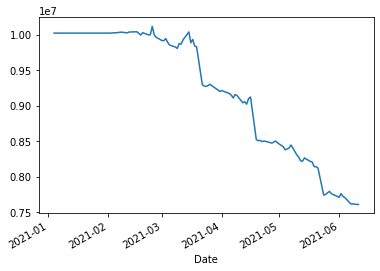

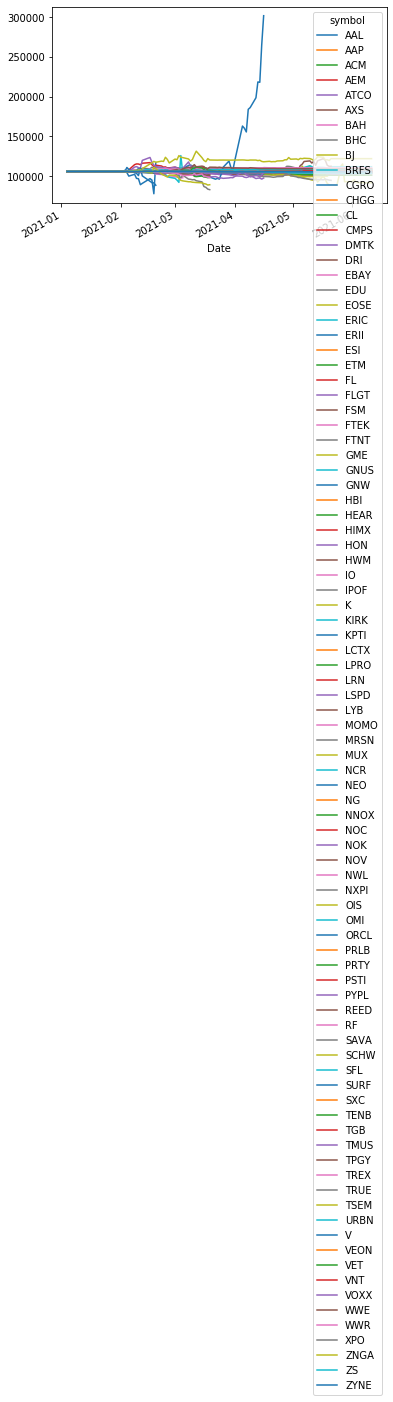

In [634]:
portfolio.value().sum(axis=1).plot()
portfolio.value(group_by='symbol').plot()

In [631]:
# portfolio['AAL'].value().sum(axis=1)
# portfolio.value(group_by='symbol').plot()#.sum(axis=1)
portfolio.value(group_by='symbol')['ORCL']#.plot()

Date
2021-01-04    105947.517
2021-01-05    105947.517
2021-01-06    105947.517
2021-01-07    105947.517
2021-01-08    105947.517
                 ...    
2021-06-07           NaN
2021-06-08           NaN
2021-06-09           NaN
2021-06-10           NaN
2021-06-11           NaN
Name: ORCL, Length: 111, dtype: float64

In [633]:
df[df['s_hx_symbol'] == 'ORCL']

contract_symbol  y_pred purch_date  \
oc_hx_date oc_hx_contract_symbol                                      
2021-01-04 ORCL210212C00064000               NaN     NaN        NaN   
           ORCL210219C00065000               NaN     NaN        NaN   
           ORCL210319C00070000               NaN     NaN        NaN   
           ORCL210319C00080000               NaN     NaN        NaN   
2021-01-05 ORCL210212C00064000               NaN     NaN        NaN   
...                                          ...     ...        ...   
2021-05-21 ORCL210521C00075000               NaN     NaN        NaN   
           ORCL210521C00077500               NaN     NaN        NaN   
           ORCL210521C00080000               NaN     NaN        NaN   
           ORCL210521C00082500               NaN     NaN        NaN   
           ORCL210521C00085000               NaN     NaN        NaN   

                                 purch_datetime  trade_price  \
oc_hx_date oc_hx_contract_symbol                               
2021-01-04 ORCL210212C00064000              NaN          NaN   
           ORCL210219C00065000              NaN          NaN   
           ORCL210319C00070000              NaN          NaN   
           ORCL210319C00080000              NaN          NaN   
2021-01-05 ORCL210212C00064000              NaN          NaN   
...                                         ...          ...   
2021-05-21 ORCL210521C00075000              NaN          NaN   
           ORCL210521C00077500              NaN          NaN   
           ORCL210521C00080000              NaN          NaN   
           ORCL210521C00082500              NaN          NaN   
           ORCL210521C00085000              NaN          NaN   

                                  open_day_after_purch  lo_day_after_purch  \
oc_hx_date oc_hx_contract_symbol                                             
2021-01-04 ORCL210212C00064000                     NaN                 NaN   
           ORCL210219C00065000                     NaN                 NaN   
           ORCL210319C00070000                     NaN                 NaN   
           ORCL210319C00080000                     NaN                 NaN   
2021-01-05 ORCL210212C00064000                     NaN                 NaN   
...                                                ...                 ...   
2021-05-21 ORCL210521C00075000                     NaN                 NaN   
           ORCL210521C00077500                     NaN                 NaN   
           ORCL210521C00080000                     NaN                 NaN   
           ORCL210521C00082500                     NaN                 NaN   
           ORCL210521C00085000                     NaN                 NaN   

                                  win  loss  close_day_of_exp  ...  oc_hx_hi  \
oc_hx_date oc_hx_contract_symbol                               ...             
2021-01-04 ORCL210212C00064000    NaN   NaN               NaN  ...      1.75   
           ORCL210219C00065000    NaN   NaN               NaN  ...      1.88   
           ORCL210319C00070000    NaN   NaN               NaN  ...      1.01   
           ORCL210319C00080000    NaN   NaN               NaN  ...      0.19   
2021-01-05 ORCL210212C00064000    NaN   NaN               NaN  ...      1.27   
...                               ...   ...               ...  ...       ...   
2021-05-21 ORCL210521C00075000    NaN   NaN               NaN  ...      4.75   
           ORCL210521C00077500    NaN   NaN               NaN  ...      2.35   
           ORCL210521C00080000    NaN   NaN               NaN  ...      0.22   
           ORCL210521C00082500    NaN   NaN               NaN  ...      0.03   
           ORCL210521C00085000    NaN   NaN               NaN  ...      0.01   

                                  oc_hx_lo  oc_hx_open  oc_hx_close  \
oc_hx_date oc_hx_contract_symbol                                      
2021-01-04 ORCL210212C00064000        1.63        1.75         1.63   
       

In [951]:
# portfolio.plot(column='BTC-USD')
# portfolio.plot(index='BTC-USD')
portfolio.stats()

Start                     2019-01-02 00:00:00
End                       2021-01-22 00:00:00
Duration                    440 days 00:00:00
Init. Cash                            911.821
Total Profit                          5659.43
Total Return [%]                      620.673
Benchmark Return [%]                  249.403
Position Coverage [%]                 3.13131
Max. Drawdown [%]                     21.9264
Avg. Drawdown [%]                     13.8066
Max. Drawdown Duration       11 days 16:00:00
Avg. Drawdown Duration        7 days 09:46:40
Num. Trades                                 1
Win Rate [%]                              100
Best Trade [%]                        1680.42
Worst Trade [%]                       1680.42
Avg. Trade [%]                        1680.42
Max. Trade Duration          13 days 18:40:00
Avg. Trade Duration          13 days 18:40:00
Expectancy                            5659.43
SQN                                       NaN
Gross Exposure                    

In [954]:
portfolio.get_trades()